In [90]:
import json

import albumentations
import tensorstore

from deep_ccf_registration.metadata import SubjectMetadata, AcquisitionDirection, AcquisitionAxis
from deep_ccf_registration.utils.tensorstore_utils import create_kvstore
from loguru import logger


In [2]:
import os

os.environ['AWS_ACCESS_KEY_ID']= ""
os.environ['AWS_SECRET_ACCESS_KEY']= ""
os.environ['AWS_SESSION_TOKEN'] = ""

In [361]:
from dataclasses import dataclass

@dataclass
class ObliqueSliceParams:
    """Parameters for sampling an oblique slice."""
    x_rot: float = 0.0
    y_rot: float = 0.0
    z_rot: float = 0.0

    @classmethod
    def sample(
        cls,
        slice_idx: int,
        chunk_slices: tuple[slice, slice, slice],
        vol_shape: tuple[int, int, int],
        slice_axis: int,
        rng,
        x_range: tuple[int, int] = (0, 0),
        y_range: tuple[int, int] = (0, 0),
        z_range: tuple[int, int] = (0, 0),
    ):
        valid_angles = compute_valid_rotation_range(
            slice_idx=slice_idx,
            chunk_slices=chunk_slices,
            vol_shape=vol_shape,
            slice_axis=slice_axis,
            x_rot_range=x_range,
            y_rot_range=y_range,
        )

        valid_angles.append(z_range)

        angles = []
        ranges = [x_range, y_range, z_range]
        for i, angle_name in enumerate(('x_rot', 'y_rot', 'z_rot')):
            angle = rng.uniform(*ranges[i])
            if angle < valid_angles[i][0] or angle > valid_angles[i][1]:
                if ranges[i][0] != 0 and angle < valid_angles[i][0]:
                    angle = valid_angles[i][0]
                    print(f'setting {angle_name} to {angle}')
                elif ranges[i][1] != 0 and angle > valid_angles[i][1]:
                    angle = valid_angles[i][1]
                    print(f'setting {angle_name} to {angle}')
            angles.append(angle)

        return cls(
            x_rot=float(angles[0]),
            y_rot=float(angles[1]),
            z_rot=float(angles[2])
        )


In [374]:
class ObliqueSliceSampler:
    """
    Samples oblique slices from a 3D volume by rotating the sampling plane.
    """

    def extract_oblique_coords(
        self,
        crop_size: tuple,
        slice_crop_center: tuple,
        params: ObliqueSliceParams,
        slice_idx: int,
        slice_axis: int,
    ):
        """
        Args:
            crop_size: (height, width) of output
            center: Center position of crop in volume coordinates
            params: ObliqueSliceParams with x_rot, y_rot, z_rot
            slice_axis: Axis perpendicular to slice plane
        """
        crop_h, crop_w = crop_size
        in_plane_axes = [i for i in range(3) if i != slice_axis]
        in_plane_axis_0 = in_plane_axes[0]
        in_plane_axis_1 = in_plane_axes[1]

        # Build output grid centered at origin
        grid_0 = np.arange(crop_h) - (crop_h - 1) / 2.0
        grid_1 = np.arange(crop_w) - (crop_w - 1) / 2.0
        centered_0, centered_1 = np.meshgrid(grid_0, grid_1, indexing='ij')

        # Apply z-rotation
        theta_z = np.radians(-params.z_rot)
        cos_z, sin_z = np.cos(theta_z), np.sin(theta_z)

        rotated_0 = cos_z * centered_0 - sin_z * centered_1
        rotated_1 = sin_z * centered_0 + cos_z * centered_1

        # Compute slice offset
        slice_offset = rotated_0 * np.tan(np.radians(params.y_rot)) \
                     + rotated_1 * np.tan(np.radians(params.x_rot))

        # Center in volume coordinates
        center = [None, None, None]
        center[slice_axis] = slice_idx
        center[in_plane_axis_0] = slice_crop_center[0]
        center[in_plane_axis_1] = slice_crop_center[1]

        # Map to volume coordinates
        coords = [None, None, None]
        coords[slice_axis] = center[slice_axis] + slice_offset
        coords[in_plane_axis_0] = center[in_plane_axis_0] + rotated_0
        coords[in_plane_axis_1] = center[in_plane_axis_1] + rotated_1

        return coords

In [393]:
from deep_ccf_registration.metadata import SliceOrientation
from scipy.ndimage import map_coordinates
import numpy as np
from skimage.exposure import rescale_intensity
from matplotlib import pyplot as plt


def visualize_oblique_slice(
    subject_id: str,
    oblique_slice_params: Optional[ObliqueSliceParams] = None,
    orientation: Optional[SliceOrientation] = SliceOrientation.SAGITTAL,
    slice_idx: int = 360,
    crop_size: Optional[tuple[int, int]] = None,
    slice_crop_center: Optional[tuple[int, int]] = None,  # (center_0, center_1) in volume coords for in-plane axes
):
    with open('/Users/adam.amster/smartspim-registration/subject_metadata.json') as f:
        subject_meta = json.load(f)
    subject_meta = [x for x in subject_meta if x['subject_id'] == subject_id][0]
    subject_meta = SubjectMetadata(**subject_meta)

    volume = tensorstore.open(
                    spec={
                        "driver": "auto",
                        "kvstore": create_kvstore(
                            path=subject_meta.stitched_volume_path + '/3',
                            aws_credentials_method='anonymous',
                        ),
                    },
                    read=True,
                ).result()

    if orientation == SliceOrientation.SAGITTAL:
        slice_axis = [x for x in subject_meta.axes if x.direction in (AcquisitionDirection.RIGHT_TO_LEFT, AcquisitionDirection.LEFT_TO_RIGHT)][0]
    elif orientation == SliceOrientation.CORONAL:
        slice_axis = [x for x in subject_meta.axes if x.direction in (AcquisitionDirection.ANTERIOR_TO_POSTERIOR, AcquisitionDirection.POSTERIOR_TO_ANTERIOR)][0]
    else:
        raise ValueError()

    in_plane_axes = [i for i in range(3) if i != slice_axis.dimension]
    in_plane_axis_0 = in_plane_axes[0]
    in_plane_axis_1 = in_plane_axes[1]

    spatial_shape = volume.shape[2:]

    if oblique_slice_params is None:
        slices = [0, 0, None, None, None]
        slices[slice_axis.dimension + 2] = slice(slice_idx, slice_idx + 1)
        slices[in_plane_axis_0 + 2] = slice(0, spatial_shape[in_plane_axis_0])
        slices[in_plane_axis_1 + 2] = slice(0, spatial_shape[in_plane_axis_1])
        img = volume[tuple(slices)].read().result()
    else:
        sampler = ObliqueSliceSampler()

        # 1. Compute rotated coordinates in VOLUME space
        coords = sampler.extract_oblique_coords(
            params=oblique_slice_params,
            slice_axis=slice_axis.dimension,
            crop_size=crop_size,
            slice_idx=slice_idx,
            slice_crop_center=tuple(slice_crop_center),
        )

        # 2. Find bounding box of coordinates (what we need to load)
        mins = [max(0, int(np.floor(c.min()))) for c in coords]
        maxs = [min(spatial_shape[i], int(np.ceil(c.max())) + 1) for i, c in enumerate(coords)]

        chunk_slices = tuple(slice(mn, mx) for mn, mx in zip(mins, maxs))

        print(f'loading chunk region {chunk_slices}')

        # 3. Load only the required chunk
        chunk = volume[(0, 0, *chunk_slices)].read().result()

        # 4. Offset coordinates to chunk-local space
        coords_local = [c - chunk_slices[i].start for i, c in enumerate(coords)]

        # 5. Sample
        img = map_coordinates(
            input=chunk,
            coordinates=coords_local,
            order=1,
            mode='constant',
            cval=0.0
        )

    low, high = np.percentile(img, (1, 99))
    img = rescale_intensity(
            img,
            in_range=tuple((low, high)),
            out_range=(0, 1)
        )
    return img.squeeze()

In [369]:
def compute_valid_rotation_range(
    slice_idx: int,
    chunk_slices: tuple[slice, slice, slice],
    vol_shape: tuple[int, int, int],
    slice_axis: int,
    x_rot_range: tuple[int, int],
    y_rot_range: tuple[int, int],
) -> list[tuple[float, float], tuple[float, float]]:
    """
    Compute valid (min, max) ranges accounting for combined rotation effects.
    """
    in_plane_axes = [i for i in range(3) if i != slice_axis]
    in_plane_axis_0 = in_plane_axes[0]
    in_plane_axis_1 = in_plane_axes[1]
    half_0 = vol_shape[in_plane_axis_0] / 2.0
    half_1 = vol_shape[in_plane_axis_1] / 2.0
    chunk_start = chunk_slices[slice_axis].start
    chunk_end = chunk_slices[slice_axis].stop
    headroom_low = slice_idx - chunk_start
    headroom_high = chunk_end - slice_idx

    # The maximum combined offset at a corner is ADDITIVE:
    # offset = half_0 * tan(y_rot) + half_1 * tan(x_rot)
    # This must be <= headroom
    # So use (half_0 + half_1) as the denominator
    max_combined_angle_high = np.degrees(np.arctan(headroom_high / (half_0 + half_1)))
    max_combined_angle_low = np.degrees(np.arctan(headroom_low / (half_0 + half_1)))

    x_rot_range = (
        max(x_rot_range[0], -max_combined_angle_low),
        min(x_rot_range[1], max_combined_angle_high)
    )
    y_rot_range = (
        max(y_rot_range[0], -max_combined_angle_low),
        min(y_rot_range[1], max_combined_angle_high)
    )

    return [x_rot_range, y_rot_range]

KeyboardInterrupt: 

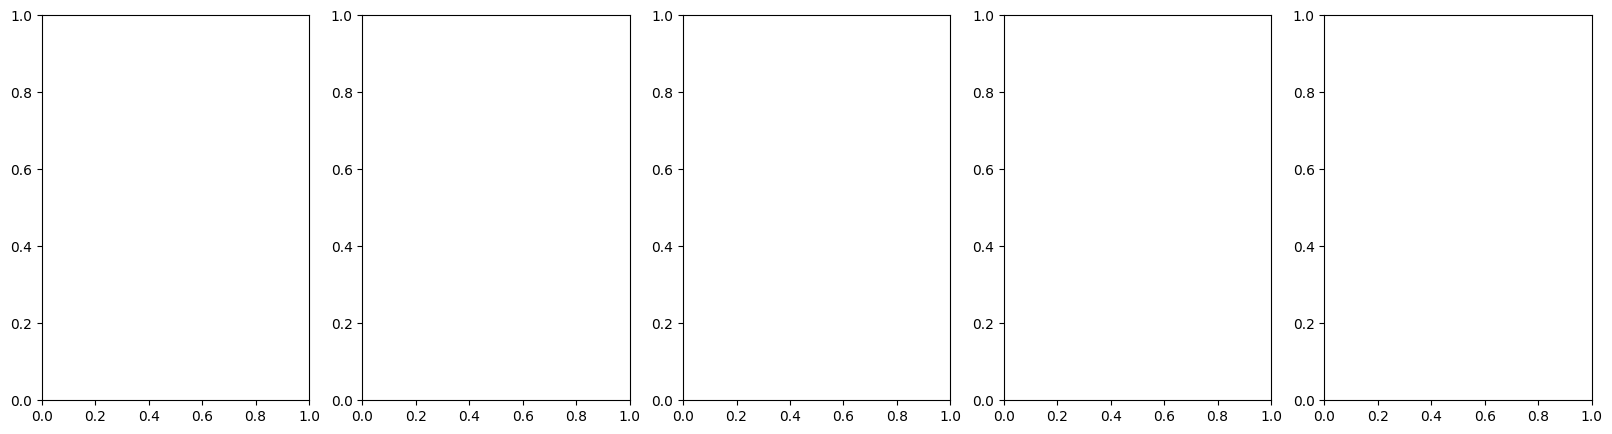

In [187]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
img = visualize_oblique_slice(subject_id='806624')
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

rotation_stats = RotationStats()
for i in range(1, 5):
    params = ObliqueSliceParams(
            ap_axis_rotation=rng.uniform(low=rotation_stats.roll_min, high=rotation_stats.roll_max)[0],
            ml_axis_rotation=rng.uniform(low=rotation_stats.pitch_min, high=rotation_stats.pitch_max)[0],
            si_axis_rotation=rng.uniform(low=rotation_stats.yaw_min, high=rotation_stats.yaw_max)[0]
    )
    img = visualize_oblique_slice(subject_id='806624', oblique_slice_params=params)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Roll: {params.ap_axis_rotation:.3f}, pitch: {params.ml_axis_rotation:.3f}, yaw: {params.si_axis_rotation:.3f}')
plt.show()

loading chunk region (slice(277, 444, None), slice(0, 832, None), slice(0, 480, None))
loading chunk region (slice(293, 428, None), slice(0, 829, None), slice(0, 480, None))
loading chunk region (slice(294, 427, None), slice(0, 835, None), slice(0, 480, None))
loading chunk region (slice(326, 395, None), slice(0, 796, None), slice(0, 480, None))


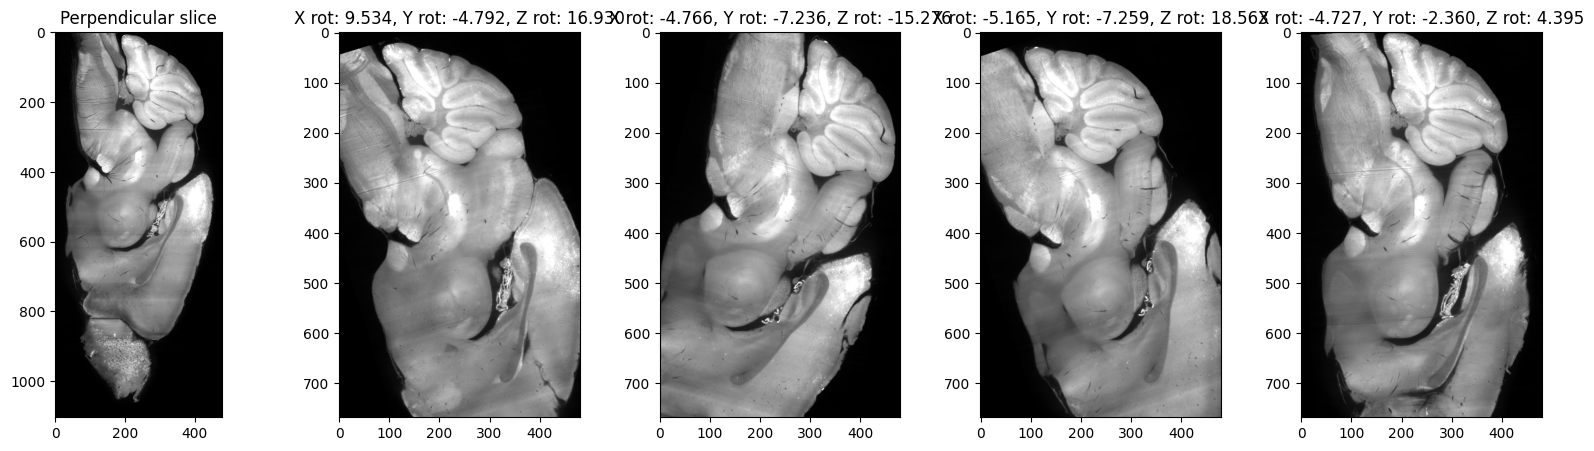

In [394]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
slice_idx = 360
chunk_slices = (slice(slice_idx-int(400/2), slice_idx+int(400/2)), slice(0,768), slice(0,480))

img = visualize_oblique_slice(
    subject_id='806624',
    slice_idx=slice_idx,

)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

for i in range(1, 5):
    params = ObliqueSliceParams.sample(
        slice_idx=slice_idx,
        chunk_slices=chunk_slices,
        vol_shape=(720,1104,480),
        slice_axis=0,
        rng=rng,
        x_range=(-10, 10),
        y_range=(-20, 20),
        z_range=(-20, 20),
    )

    img = visualize_oblique_slice(
        subject_id='806624',
        oblique_slice_params=params,
        slice_idx=slice_idx,
        crop_size=(768, 480),
        slice_crop_center=(394, 480 // 2)
    )

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'X rot: {params.x_rot:.3f}, Y rot: {params.y_rot:.3f}, Z rot: {params.z_rot:.3f}')
plt.show()

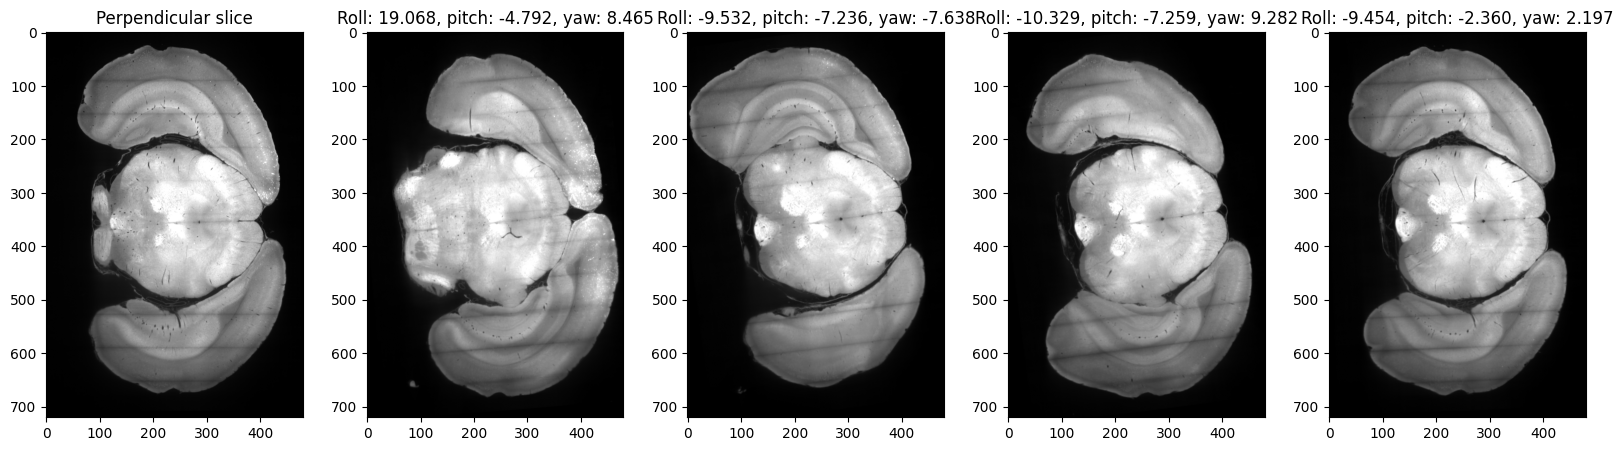

In [144]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
img = visualize_oblique_slice(subject_id='806624', orientation=SliceOrientation.CORONAL)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

rotation_stats = RotationStats()
for i in range(1, 5):
    params = ObliqueSliceParams(
            ap_axis_rotation=rng.uniform(low=rotation_stats.roll_min, high=rotation_stats.roll_max)[0],
            ml_axis_rotation=rng.uniform(low=rotation_stats.pitch_min, high=rotation_stats.pitch_max)[0],
            si_axis_rotation=rng.uniform(low=rotation_stats.yaw_min, high=rotation_stats.yaw_max)[0]
    )
    img = visualize_oblique_slice(subject_id='806624', oblique_slice_params=params, orientation=SliceOrientation.CORONAL)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Roll: {params.ap_axis_rotation:.3f}, pitch: {params.ml_axis_rotation:.3f}, yaw: {params.si_axis_rotation:.3f}')
plt.show()

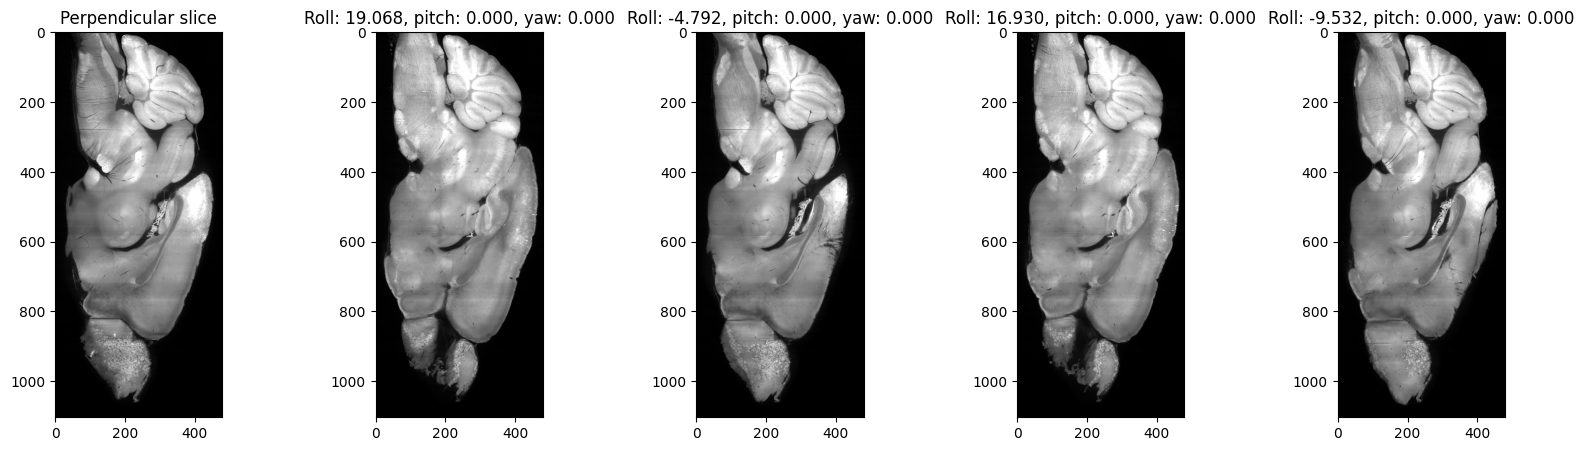

In [139]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
img = visualize_oblique_slice(subject_id='806624')
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

rotation_stats = RotationStats()
for i in range(1, 5):
    params = ObliqueSliceParams(
            ap_axis_rotation=rng.uniform(low=rotation_stats.roll_min, high=rotation_stats.roll_max)[0],
            ml_axis_rotation=0.0,
            si_axis_rotation=0.0
    )
    img = visualize_oblique_slice(subject_id='806624', oblique_slice_params=params)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Roll: {params.ap_axis_rotation:.3f}, pitch: {params.ml_axis_rotation:.3f}, yaw: {params.si_axis_rotation:.3f}')
plt.show()

ObliqueSliceParams(roll=0.0, pitch=np.float64(19.067990667925688), yaw=0)
ML 360.000 - 360.000 AP -47.792 - 1151.173 SI -167.164 - 645.893
ObliqueSliceParams(roll=0.0, pitch=np.float64(-4.7921705992152885), yaw=0)
ML 360.000 - 360.000 AP -18.120 - 1121.040 SI -45.192 - 524.280
ObliqueSliceParams(roll=0.0, pitch=np.float64(16.929849350558218), yaw=0)
ML 360.000 - 360.000 AP -45.674 - 1149.009 SI -150.342 - 629.094
ObliqueSliceParams(roll=0.0, pitch=np.float64(-9.532303045458232), yaw=0)
ML 360.000 - 360.000 AP -32.123 - 1134.971 SI -87.934 - 567.113


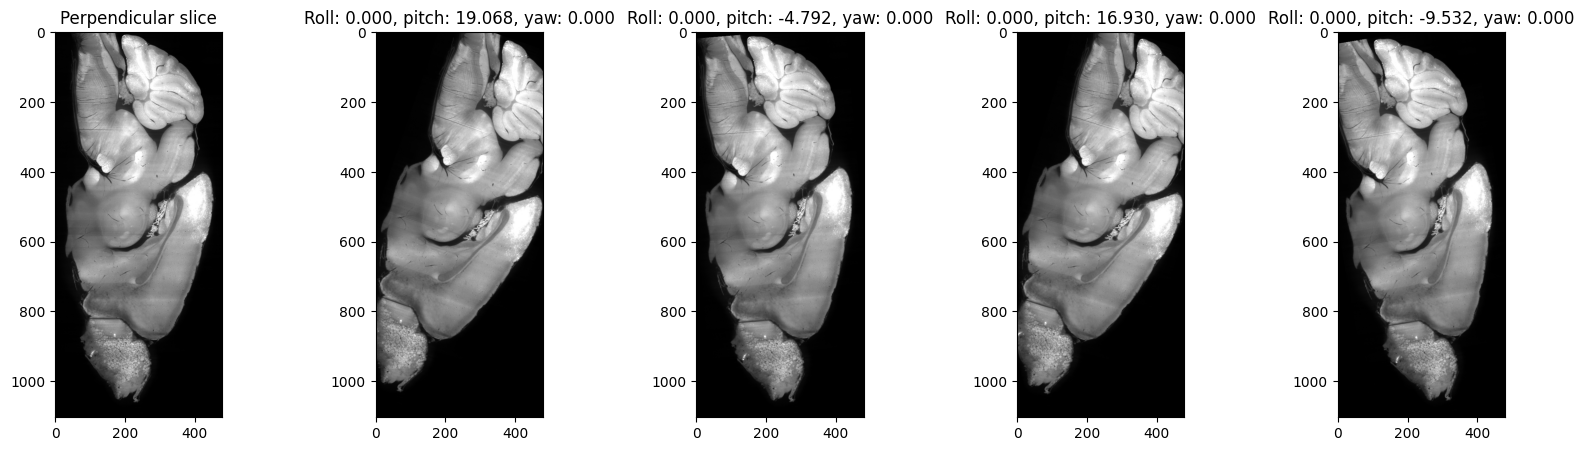

In [121]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
img, _ = visualize_oblique_slice(subject_id='806624', enable_oblique_sampling=False, rng=rng)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

for i in range(1, 5):
    img, params = visualize_oblique_slice(subject_id='806624', rng=rng)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Roll: {params.ap_axis_rotation:.3f}, pitch: {params.ml_axis_rotation:.3f}, yaw: {params.si_axis_rotation:.3f}')
plt.show()

ObliqueSliceParams(roll=0.0, pitch=0.0, yaw=np.float64(9.533995333962844))
ML 267.290 - 452.542 AP 0.000 - 1103.000 SI 0.000 - 479.000
ObliqueSliceParams(roll=0.0, pitch=0.0, yaw=np.float64(-2.3960852996076443))
ML 336.944 - 383.098 AP 0.000 - 1103.000 SI 0.000 - 479.000
ObliqueSliceParams(roll=0.0, pitch=0.0, yaw=np.float64(8.464924675279109))
ML 277.848 - 442.003 AP 0.000 - 1103.000 SI 0.000 - 479.000
ObliqueSliceParams(roll=0.0, pitch=0.0, yaw=np.float64(-4.766151522729116))
ML 314.059 - 406.024 AP 0.000 - 1103.000 SI 0.000 - 479.000


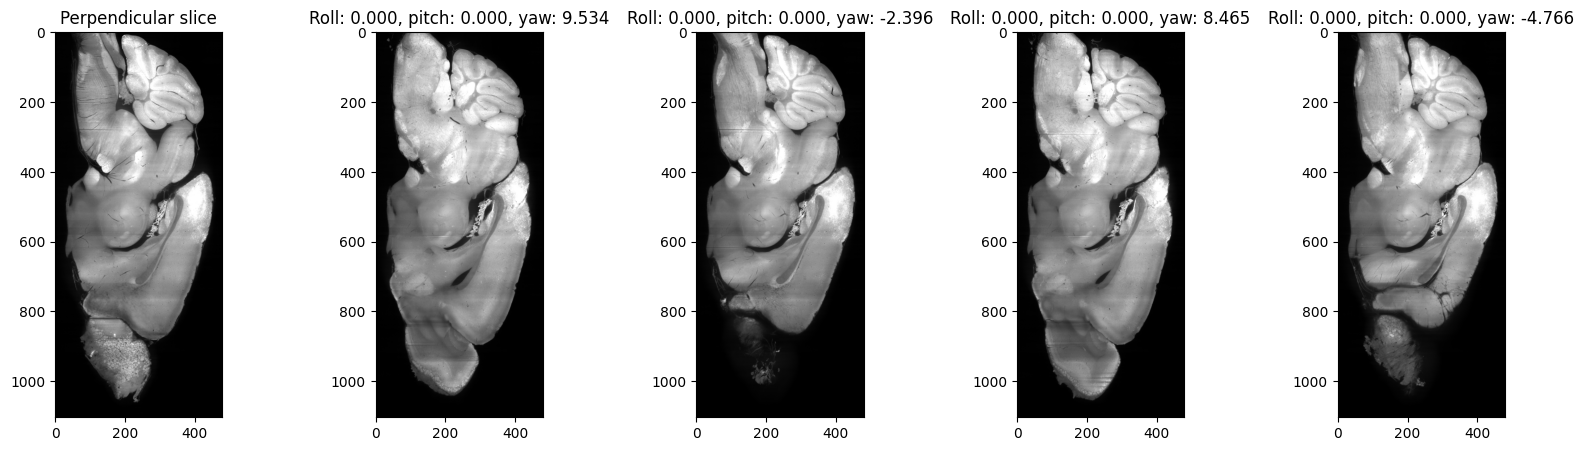

In [123]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
img, _ = visualize_oblique_slice(subject_id='806624', enable_oblique_sampling=False, rng=rng)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

for i in range(1, 5):
    img, params = visualize_oblique_slice(subject_id='806624', rng=rng)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Roll: {params.ap_axis_rotation:.3f}, pitch: {params.ml_axis_rotation:.3f}, yaw: {params.si_axis_rotation:.3f}')
plt.show()

2026-01-16 12:55:05.968 | INFO     | __main__:extract_oblique_coords:95 - ObliqueSliceParams(roll=np.float64(19.067990667925688), pitch=np.float64(-4.7921705992152885), yaw=np.float64(8.464924675279109))
2026-01-16 12:55:05.971 | INFO     | __main__:extract_oblique_coords:96 - ['-87.056 - 613.565', '4.910 - 1134.313', '193.605 - 540.136']
2026-01-16 12:55:13.167 | INFO     | __main__:extract_oblique_coords:95 - ObliqueSliceParams(roll=np.float64(-9.532303045458232), pitch=np.float64(-7.236117663432098), yaw=np.float64(-7.638175340667144))
2026-01-16 12:55:13.169 | INFO     | __main__:extract_oblique_coords:96 - ['-59.361 - 680.622', '-41.722 - 1113.140', '241.101 - 483.556']
2026-01-16 12:55:24.288 | INFO     | __main__:extract_oblique_coords:95 - ObliqueSliceParams(roll=np.float64(-10.329348269888596), pitch=np.float64(-7.258642848710943), yaw=np.float64(9.281584903567525))
2026-01-16 12:55:24.290 | INFO     | __main__:extract_oblique_coords:96 - ['-25.489 - 657.168', '-12.779 - 1144.

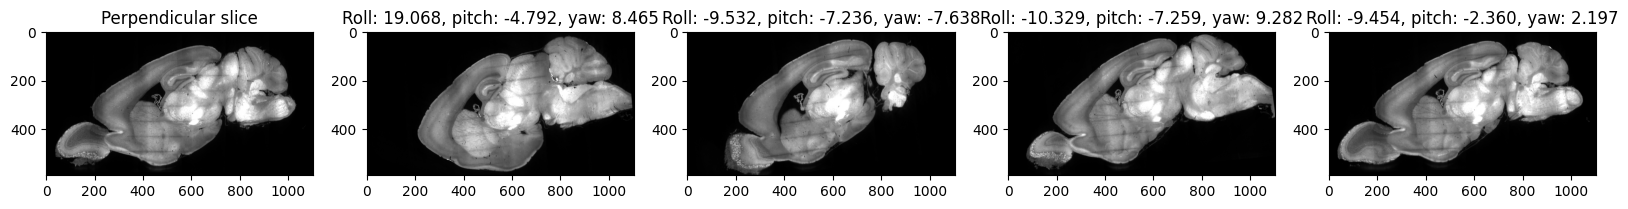

In [100]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
img, _ = visualize_oblique_slice(subject_id='791691', enable_oblique_sampling=False, rng=rng)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Perpendicular slice')

for i in range(1, 5):
    img, params = visualize_oblique_slice(subject_id='791691', rng=rng)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Roll: {params.ap_axis_rotation:.3f}, pitch: {params.ml_axis_rotation:.3f}, yaw: {params.si_axis_rotation:.3f}')
plt.show()